## 1. Librarie's import

In [56]:
from os import listdir
from os.path import isfile, join

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import pandas as pd

import soundfile as sf
from scipy import signal
import random
import librosa

## 2. Loading OGG files (audio files)

In [82]:
def load_ogg_file(filename, max_ms = 5000):
    # Load encoded wav file
    x, fs = sf.read(filename)
    # Sampling frequency of the ADC
    sr = 10447
    M = fs//sr
    # Resampling the audio file from 44100 Hz to 10200
    sig = signal.resample(x, int(len(x)/M))
    
    sig_len = len(sig)
    max_len = int(sr * max_ms/1000)

    if (sig_len > max_len):
        sig = sig[:max_len]

    elif (sig_len < max_len):
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = np.zeros(pad_begin_len)
        pad_end = np.zeros(pad_end_len)

        sig = np.concatenate((pad_begin, sig, pad_end))
        
    return sig

## 3. Dataframe with audio resampled

In [63]:
soundfiles = ['203 - Crackling fire', '205 - Chirping birds', '501 - Helicopter', '502 - Chainsaw', '510 - Hand saw' ]
original_audio = np.array([[mypath + "/" + f for f in listdir(mypath) if isfile(join(mypath, f))] for mypath in ["Dataset_ESC-50/" + soundfiles[i] for i in range(len(soundfiles))]])
audio_df = pd.DataFrame(data = original_audio.T, columns = soundfiles)

In [50]:
df = audio_df.applymap(load_ogg_file)

## 4. Melspectrograms

In [140]:
def melspectrogram(x, Nft = 512, fs_down = 10447, Nmel = 20) :
    """
    Pre : x is the resampled signal
    Post : melspectrogram of x
    """

    L = len(x)
    x_crop = x[:L-L%Nft]
    x_new = x_crop if len(x.shape)==1 else np.mean(x_crop,axis=1)
    L_new = len(x_new)
    
    audiomat = np.reshape(x_new, (L_new//Nft,Nft))
    audioham = audiomat*np.hamming(Nft) # Windowing.
    z = np.reshape(audioham,-1) # y windowed by pieces

    stft = np.fft.fft(audioham, axis=1)
    stft = np.abs(stft[:,:Nft//2].T) # Taking only positive frequencies and computing the magnitude
    
    mels = librosa.filters.mel(sr=fs_down, n_fft=Nft, n_mels=Nmel)
    mels = mels[:,:-1]
    mels = mels/np.max(mels)
    
    melspec = mels@stft
    
    return melspec

## 5. Creating an entire dataset from audio path

### 5.1 Audio transformations

In [69]:
def add_bg(filename1, filename2, amplitude_limit=0.1):
    sig1,sr1 = sf.read(filename1)
    sig2, sr2 = sf.read(filename2)
    sig = sig + sig2[:len(sig)] * np.max(sig)/np.max(sig2) * np.random.uniform(0,amplitude_limit)
    return (sig, sr)

In [70]:
def scaling(aud, scaling_limit=5):
    sig,sr = aud
    sig = np.random.uniform(0,scaling_limit)*sig
    return (sig, sr)

In [71]:
def add_noise(aud, sigma=0.05):
    sig,sr = aud
    size = len(sig)
    random_list = np.random.normal(loc=0.0, scale=sigma, size=size)
    return (sig + random_list,sr)

### 5.2 Dataset computation

In [320]:
def dataset(paths, label, transform = False) :
    audio_df = pd.DataFrame(data = paths, columns = label)
    df = audio_df.applymap(load_ogg_file)
    df = df.applymap(melspectrogram)
    
    return df

In [322]:
df = dataset(original_audio.T, soundfiles)
df.head()

0     [[0.16139553802987835, 1.129010422569741, 0.41...
1     [[4.599618393185904, 1.9607167848330782, 3.081...
2     [[0.787540378164321, 0.8792895723586284, 1.456...
3     [[4.126735278843879, 3.670587144112546, 3.7741...
4     [[5.93267496180878, 7.553160828357644, 7.93457...
5     [[8.160231015977375, 12.362778200102452, 17.22...
6     [[32.25256800543975, 24.21856718333109, 14.305...
7     [[2.239038553476758, 2.3908260755103288, 1.534...
8     [[1.6761907736558503, 1.0678568658326841, 1.07...
9     [[0.46392557431342324, 0.914791191625245, 0.31...
10    [[3.9192193307934975, 2.132403247416046, 3.195...
11    [[1.5626051372709195, 0.7587131203405255, 4.37...
12    [[6.611039790105335, 3.4124891884335677, 5.573...
13    [[7.14604539860532, 4.709875319136254, 5.07816...
14    [[3.554901480241757, 7.958725974562355, 6.2002...
15    [[2.095416911361554, 3.150139072915397, 5.2143...
16    [[0.12025006156585258, 0.09648530526482016, 0....
17    [[0.21791226085080753, 0.2416150969076728,

In [324]:
df["203 - Crackling fire"][0].shape

(20, 102)

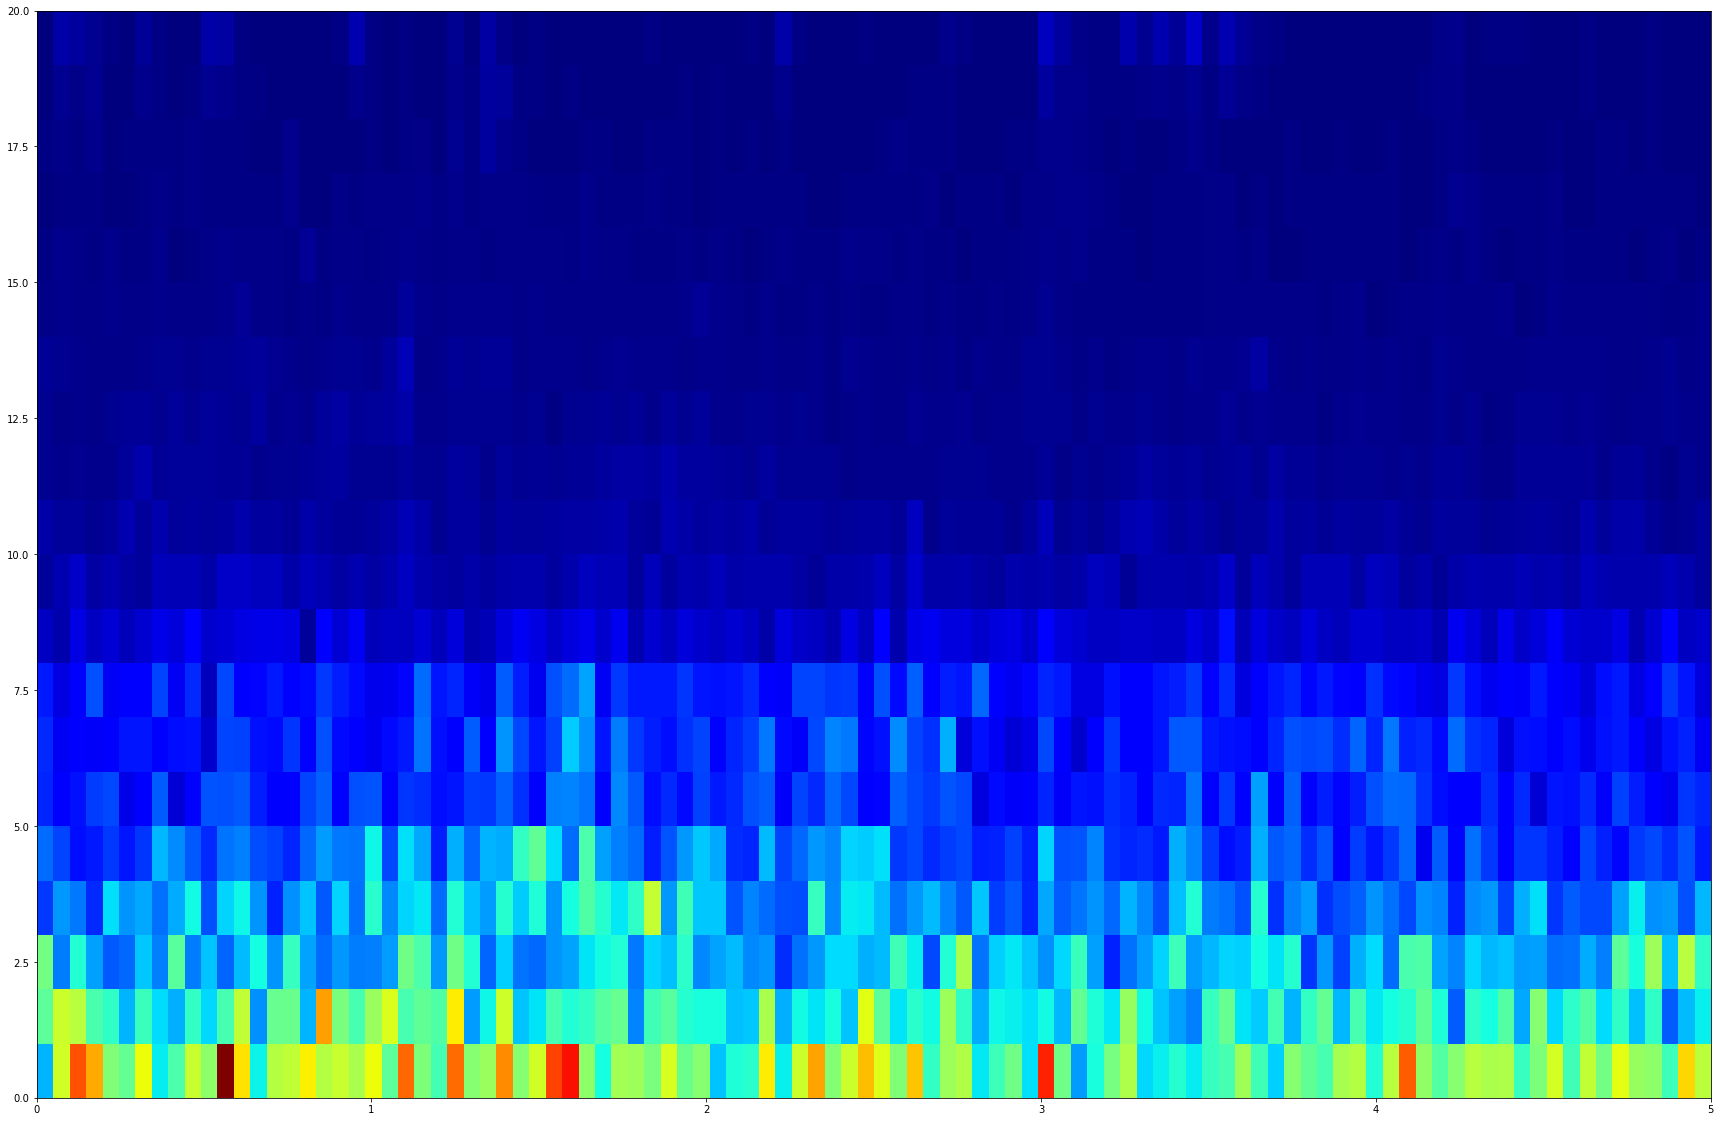

In [316]:
specgram = df.iloc[:,1][10]
plt.figure(figsize=(30,20))
plt.imshow(specgram, cmap='jet', aspect='auto', extent=[0,5,specgram.shape[0],0])
plt.gca().invert_yaxis()

## 6. Classification using CNN

### 6.1 Network definition

In [305]:
class MelSpecClassifier (nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2)
        self.relu1 = nn.PReLU()
        self.bn1 = nn.BatchNorm2d(8)
        conv_layers += [self.conv1, self.relu1, self.bn1]
        
        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.PReLU()
        self.bn2 = nn.BatchNorm2d(16)
        conv_layers += [self.conv2, self.relu2, self.bn2]
        
        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.PReLU()
        self.bn3 = nn.BatchNorm2d(32)
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.relu4 = nn.PReLU()
        self.bn4 = nn.BatchNorm2d(64)
        conv_layers += [self.conv4, self.relu4, self.bn4]
        
        # Fifth Convolution Block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.relu5 = nn.PReLU()
        self.bn5 = nn.BatchNorm2d(128)
        conv_layers += [self.conv5, self.relu5, self.bn5]
        
        
        # Dropout Layer
        self.drp = nn.Dropout2d(p = 0.2)
        
        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(in_features=128, out_features=5)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
        self.initialize_weights()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.drp(x)
        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x


    def initialize_weights(self) :
        for m in self.modules() :
            if isinstance(m, nn.Conv2d) :
                nn.init.kaiming_normal_(m.weight, a = 0.1)
                if m.bias is not None :
                    nn.init.constant_(m.bias, 0)

### 6.2 Custom dataset

In [269]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        col = ["data", "label"]
        labels = []
        mels = []
        for i in range(len(self.df.columns)) :
            labels += [i] * len(self.df[self.df.columns[i]])

        for i in self.df.columns :
            for j in self.df[i].values :
                mels.append(j)
        row = [mels, labels]      
        dic = {col[i]: row[i] for i in range(len(col))}
        self.data = pd.DataFrame.from_dict(dic)
        
    def __len__(self):
        return len(self.df)    

    def __getitem__(self, idx):
        specgram = torch.Tensor(self.data["data"][idx]).unsqueeze(0)
        class_label = torch.tensor(self.data["label"][idx])
        return specgram, class_label

### 6.3 Dataset matching specifications
- ADC samples the signal received from the microphone at a 10447 Hz
- 20 melvectors are computed with ONLY 10 components (here we have 102)

In [377]:
def shaping_audio(audio, dic, col, nb = 10, sr=10447) :
    sig = load_ogg_file(audio)
    sig_len = sig.shape[0]
    L = sig_len//nb
    for i in range(nb) :
        mels = melspectrogram(sig[i*L:(i+1)*L])
        dic[col].append(mels)

In [378]:
audio_df = pd.DataFrame(data = original_audio.T, columns = soundfiles)
dic = {}
for i in audio_df.columns : 
    print(i)
    dic[i] = []
    for j in audio_df[i].values :
        shaping_audio(j, dic, i)

aug_df = pd.DataFrame.from_dict(dic)
aug_df.head()

203 - Crackling fire
205 - Chirping birds
501 - Helicopter
502 - Chainsaw
510 - Hand saw


,203 - Crackling fire,205 - Chirping birds,501 - Helicopter,502 - Chainsaw,510 - Hand saw
0,"[[0.16139553802987835, 1.129010422569741, 0.41...","[[0.28009388384273526, 0.19227444108293093, 0....","[[34.67986352239215, 55.242985228413545, 47.20...","[[4.106173216198236, 9.108093557076055, 6.5726...","[[0.6273128829696692, 0.3741801137366557, 2.05..."
1,"[[3.732584836940183, 3.9830244905298304, 2.425...","[[0.357553731078016, 0.16968612608022732, 0.20...","[[29.766596234110676, 44.22295917565828, 34.18...","[[2.4146751082115276, 2.754611860965592, 3.327...","[[2.8931556147528434, 2.1534727679317744, 2.23..."
2,"[[4.371155005453969, 4.089171703129612, 3.9965...","[[0.2376869991309269, 0.2034270323990362, 0.13...","[[48.20388422417473, 74.96856166125248, 35.884...","[[13.078857973612873, 14.290174093709314, 16.7...","[[3.182896821300265, 4.587765707403446, 2.9535..."
3,"[[3.79783495528626, 4.445299806036989, 6.09326...","[[0.20967773527179576, 0.1865186136598542, 0.1...","[[46.762472275332065, 53.56623531295734, 51.70...","[[20.31230272340217, 15.398635710378757, 11.50...","[[10.554444018075369, 7.33162912604194, 5.6951..."
4,"[[3.4867688454646775, 3.1932336311397385, 3.74...","[[0.09744261148328927, 0.12295100938979744, 0....","[[30.878071744814033, 29.51933482264312, 64.04...","[[27.91011535893604, 32.68779082516277, 19.846...","[[6.01396871184163, 6.446743798329482, 7.13290..."


### 6.4 Fitting data, inference and loss

In [312]:
def inference (model, val_dl):
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            acc = correct_prediction/total_prediction
            print(f'Test Accuracy: {acc:.2f}, Total items: {total_prediction}')

    return acc

In [313]:
def training(model, train_dl, num_epochs):
    acc_train = []
    acc_test = []

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            #if i % 10 == 0:    # print every 10 mini-batches
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        acc_train.append(acc)
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Train Accuracy: {acc:.2f}')

        acc_test.append(inference(model, val_dl))


    print('Finished Training')
    return acc_train, acc_test

### 6.5 Dataset and dataloaders initializations

In [380]:
from torch.utils.data import random_split
myds = CustomDataset(aug_df)

num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

### 6.6 Training and validation steps

Epoch: 0, Loss: 1.69, Train Accuracy: 0.39
Test Accuracy: 0.44, Total items: 16
Test Accuracy: 0.41, Total items: 32
Test Accuracy: 0.35, Total items: 48
Test Accuracy: 0.38, Total items: 64
Test Accuracy: 0.41, Total items: 80
Epoch: 1, Loss: 1.25, Train Accuracy: 0.75
Test Accuracy: 0.94, Total items: 16
Test Accuracy: 0.88, Total items: 32
Test Accuracy: 0.88, Total items: 48
Test Accuracy: 0.86, Total items: 64
Test Accuracy: 0.85, Total items: 80
Epoch: 2, Loss: 0.80, Train Accuracy: 0.97
Test Accuracy: 1.00, Total items: 16
Test Accuracy: 1.00, Total items: 32
Test Accuracy: 0.98, Total items: 48
Test Accuracy: 0.98, Total items: 64
Test Accuracy: 0.99, Total items: 80
Epoch: 3, Loss: 0.32, Train Accuracy: 0.98
Test Accuracy: 1.00, Total items: 16
Test Accuracy: 1.00, Total items: 32
Test Accuracy: 1.00, Total items: 48
Test Accuracy: 1.00, Total items: 64
Test Accuracy: 1.00, Total items: 80
Epoch: 4, Loss: 0.10, Train Accuracy: 1.00
Test Accuracy: 1.00, Total items: 16
Test Acc

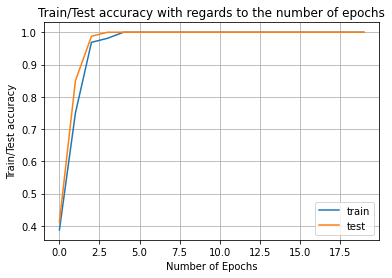

In [381]:
import matplotlib.pyplot as plt
import time

# Model Instantiation
myModel = MelSpecClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
next(myModel.parameters()).device

# Training and validation step
t_init = time.time()
num_epochs= 20
trainAcc, testAcc = training(myModel, train_dl, num_epochs)
t_final= time.time()
print("Time needed : ", t_final-t_init)

# Plotting curve of train/test accuracies with regards to the number of epochs
x = np.arange(0, num_epochs, 1)

plt.plot(x, trainAcc, label = 'train')
plt.plot(x, testAcc, label = 'test')
plt.grid()
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Train/Test accuracy")
plt.title("Train/Test accuracy with regards to the number of epochs")
plt.show()
